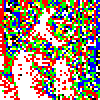

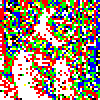


Размер матрицы: (50, 50), расстояние: Хэмминга
Потребовалось поколений: 7

Целевое изображение:

Финальный результат:

Процесс эволюции:


ProcessFailedException: Error trying to display an error.

In [23]:
using Images
using FileIO
using Base64
using Statistics
using ColorSchemes

function get_4bit_palette()
    return [
        RGB(0.0, 0.0, 0.0),    # черный
        RGB(1.0, 1.0, 1.0),     # белый
        RGB(1.0, 0.0, 0.0),     # красный
        RGB(0.0, 1.0, 0.0),     # зеленый
        RGB(0.0, 0.0, 1.0),     # синий
        RGB(1.0, 1.0, 0.0),     # желтый
        RGB(1.0, 0.0, 1.0),     # пурпурный
        RGB(0.0, 1.0, 1.0),     # голубой
        RGB(0.5, 0.0, 0.0),     # темно-красный
        RGB(0.0, 0.5, 0.0),     # темно-зеленый
        RGB(0.0, 0.0, 0.5),     # темно-синий
        RGB(0.5, 0.5, 0.0),     # оливковый
        RGB(0.5, 0.0, 0.5),     # фиолетовый
        RGB(0.0, 0.5, 0.5),     # темно-голубой
        RGB(0.5, 0.5, 0.5),     # серый
        RGB(0.8, 0.8, 0.8)      # светло-серый
    ]
end

function image_to_matrix(img_path, palette_size=16)
    img = load(img_path)
    img = imresize(img, (50, 50))  # уменьшаем для скорости работы
    img_indices = zeros(Int, size(img))
    
    for i in 1:size(img, 1), j in 1:size(img, 2)
        c = img[i,j]
        r, g, b = red(c), green(c), blue(c)
        idx = round(Int, (r + g + b) / 3 * (palette_size-1)) + 1
        img_indices[i,j] = clamp(idx, 1, palette_size)
    end
    
    return img_indices
end

# Упрощенная версия без pixel_size
function matrix_to_image(matrix, palette)
    h, w = size(matrix)
    img = Array{RGB{Float64}}(undef, h, w)
    for i in 1:h, j in 1:w
        idx = clamp(matrix[i, j], 1, length(palette))
        img[i, j] = palette[idx]
    end
    return img
end

function matrix_to_binary(matrix, bits_per_element=4)
    binary_vec = Bool[]
    for elem in matrix
        val = elem - 1
        for i in (bits_per_element-1):-1:0
            push!(binary_vec, val & (1 << i) != 0)
        end
    end
    return binary_vec
end

function binary_to_matrix(binary_vec, bits_per_element, matrix_size)
    matrix = zeros(Int, matrix_size)
    for i in 1:prod(matrix_size)
        bits = binary_vec[(i-1)*bits_per_element+1:i*bits_per_element]
        val = sum(bits .* [8, 4, 2, 1])  # 4 бита
        matrix[i] = clamp(val + 1, 1, 16)
    end
    return matrix
end

function crossover(a, b)
    n = length(a)
    child = similar(a)
    crossover_point = rand(1:n-1)
    child[1:crossover_point] = a[1:crossover_point]
    child[crossover_point+1:end] = b[crossover_point+1:end]
    return child
end

function mutate(binary_vec, mutation_rate=0.01)
    mutated = copy(binary_vec)
    for i in eachindex(mutated)
        rand() < mutation_rate && (mutated[i] = !mutated[i])
    end
    return mutated
end

function calculate_distance(a, b, use_hamming)
    if use_hamming
        return sum(a .!= b)
    else
        return sqrt(sum((a .- b).^2))
    end
end

function show_gif(frames, fps=5)
    temp_file = "evolution.gif"
    save(temp_file, cat(frames..., dims=3); fps=fps)
    println("GIF сохранен как: ", abspath(temp_file))
    return nothing
end

function run_single_experiment(target_image_path; 
                             max_generations=500, 
                             mutation_rate=0.02,
                             use_hamming=true)
    palette = get_4bit_palette()
    bits_per_element = 4
    
    # Загружаем целевое изображение
    reference = image_to_matrix(target_image_path, length(palette))
    matrix_size = size(reference)
    
    # Начальная случайная популяция
    current = rand(1:length(palette), matrix_size)
    
    frames = [matrix_to_image(current, palette)]
    distances = Float64[]
    
    generation = 0
    while generation < max_generations
        child_bin = mutate(crossover(matrix_to_binary(current), matrix_to_binary(reference)), mutation_rate)
        child = binary_to_matrix(child_bin, bits_per_element, matrix_size)
        
        dist = calculate_distance(current, reference, use_hamming)
        new_dist = calculate_distance(child, reference, use_hamming)

        if new_dist < dist
            current = child
            push!(frames, matrix_to_image(current, palette))
            push!(distances, new_dist)
        end
        generation += 1
        (new_dist == 0) && break
    end
    
    println("\nРазмер матрицы: $matrix_size, расстояние: $(use_hamming ? "Хэмминга" : "Евклидово")")
    println("Потребовалось поколений: $(length(distances))")
    
    println("\nЦелевое изображение:")
    display(matrix_to_image(reference, palette))
    
    println("\nФинальный результат:")
    display(matrix_to_image(current, palette))
    
    println("\nПроцесс эволюции:")
    show_gif(frames, 10)
    
    return distances
end

# Запуск программы
target_image = "image.jpg"  # замените на путь к вашему изображению
if isfile(target_image)
    run_single_experiment(target_image, 
                        max_generations=1000,
                        mutation_rate=0.01,
                        use_hamming=true)
else
    println("Файл $target_image не найден!")
end